In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
df = pd.read_parquet("transaction_fraud_data.parquet", engine="fastparquet")
exchange = pd.read_parquet("historical_currency_exchange.parquet", engine="fastparquet")

In [4]:
df.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,is_fraud,last_hour_activity.num_transactions,last_hour_activity.total_amount,last_hour_activity.unique_merchants,last_hour_activity.unique_countries,last_hour_activity.max_single_amount
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,197.153.60.199,False,False,False,False,1197,3.349856e+07,105,12,1.925481e+06
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,208.123.221.203,True,True,False,True,509,2.011476e+07,100,12,5.149117e+06
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,10.194.159.204,False,False,False,False,332,3.916385e+07,97,12,1.852242e+06
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,17.230.177.225,False,False,False,False,764,2.201260e+07,105,12,2.055798e+06
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,136.241.219.151,True,False,False,True,218,4.827636e+06,88,12,1.157231e+06


In [5]:
df.isnull().sum()

transaction_id                          0
customer_id                             0
card_number                             0
timestamp                               0
vendor_category                         0
vendor_type                             0
vendor                                  0
amount                                  0
currency                                0
country                                 0
city                                    0
city_size                               0
card_type                               0
is_card_present                         0
device                                  0
channel                                 0
device_fingerprint                      0
ip_address                              0
is_outside_home_country                 0
is_high_risk_vendor                     0
is_weekend                              0
is_fraud                                0
last_hour_activity.num_transactions     0
last_hour_activity.total_amount   

In [6]:
print("Всего данных: ", len(df))
print("Доля мошеннеческих транзакций: ", df['is_fraud'].sum() / len(df))

Всего данных:  7483766
Доля мошеннеческих транзакций:  0.19972818498066347


Переведем все валюты в usd.

In [7]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date
exchange['date'] = pd.to_datetime(exchange['date']).dt.date

df2 = pd.merge(
    df,
    exchange,
    on='date',
    how='left'
)

currency_to_column = {
    'AUD': 'AUD',
    'BRL': 'BRL',
    'CAD': 'CAD',
    'EUR': 'EUR',
    'GBP': 'GBP',
    'JPY': 'JPY',
    'MXN': 'MXN',
    'NGN': 'NGN',
    'RUB': 'RUB',
    'SGD': 'SGD',
    'USD': 'USD'
}

def convert_to_usd(row):
    currency = row['currency']
    amount = row['amount']
    
    if currency == 'USD':
        return amount
    
    exchange_rate_column = currency_to_column.get(currency)
    if not exchange_rate_column:
        return None
    
    exchange_rate = row[exchange_rate_column]
    if pd.isna(exchange_rate):
        return None
    
    return amount / exchange_rate

df2['amount_usd'] = df2.apply(convert_to_usd, axis=1)


In [8]:
df2['log_amount_usd'] = np.log10(df2['amount_usd'])

## Визуализация распределений

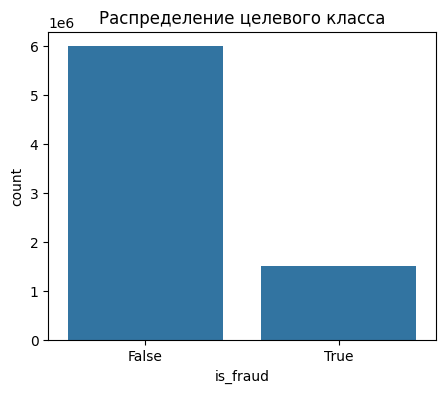

In [20]:
plt.figure(figsize=(5, 4))
sns.countplot(x='is_fraud', data=df2)
plt.title('Распределение целевого класса')
plt.show()

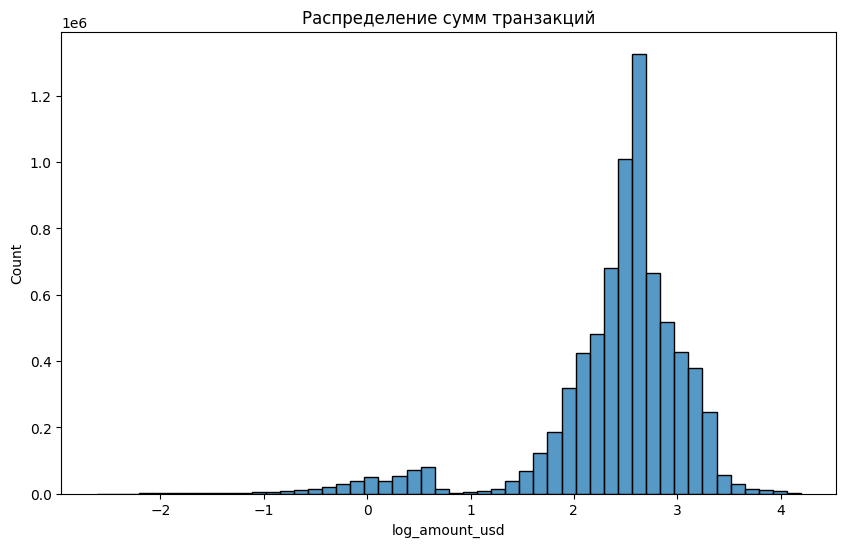

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df2['log_amount_usd'], bins=50)
plt.title('Распределение сумм транзакций')
plt.show()

Видна неоднородность распределения, возможно это вызвано мошенническими транзакциями.

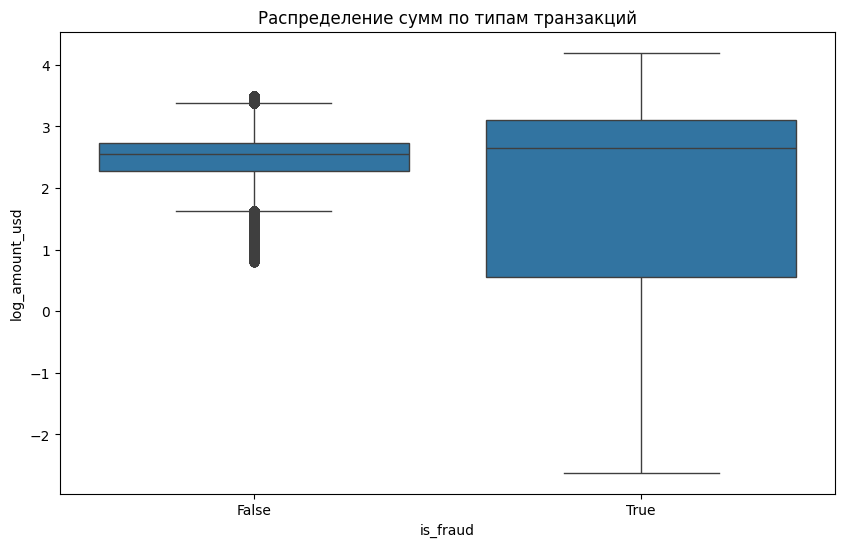

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='log_amount_usd', data=df2)
plt.title('Распределение сумм по типам транзакций')
plt.show()

Среднее примерно одинаково, но у мошеннических транзакций хвост в меньшую сторону.

<Axes: >

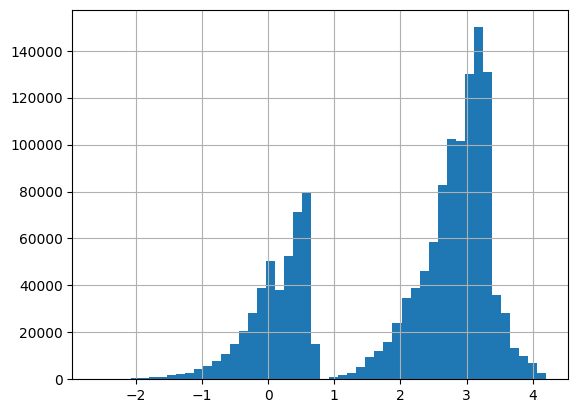

In [23]:
df2[df2['is_fraud']]['log_amount_usd'].hist(bins=50)

Видна мультимодальность в мошеннеческих транзакциях. Похоже, что мошенники сначала пытаются провернуть транзакцию с небольшой суммой.

<Axes: >

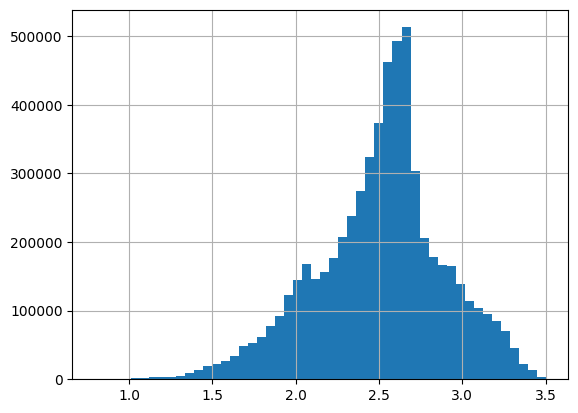

In [24]:
df2[~df2['is_fraud']]['log_amount_usd'].hist(bins=50)

Обычные транзакции имеют просто лог нормальное распределение.

### Анализ категориальных признаков

In [9]:
cat_cols = ['vendor_category', 'vendor_type', 'country', 'city_size', 
               'card_type', 'is_card_present', 'device', 'channel', 
               'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend']

In [38]:
for cat in cat_cols:
    grouped = df2.groupby(cat)['is_fraud']
    fraud_ratio = (grouped.sum() / grouped.apply(len)).sort_values()
    print(fraud_ratio)
    print("-------------")


vendor_category
Healthcare       0.199376
Retail           0.199398
Education        0.199459
Entertainment    0.199632
Restaurant       0.199696
Gas              0.199731
Grocery          0.200194
Travel           0.200341
Name: is_fraud, dtype: float64
-------------
vendor_type
medical      0.198978
premium      0.199179
casual       0.199186
online       0.199310
streaming    0.199320
hotels       0.199487
gaming       0.199558
local        0.199642
supplies     0.199758
pharmacy     0.199773
major        0.199821
events       0.200017
booking      0.200174
physical     0.200206
airlines     0.200535
fast_food    0.200719
transport    0.201169
Name: is_fraud, dtype: float64
-------------
country
Singapore    0.063557
France       0.069143
UK           0.069351
Canada       0.069988
Germany      0.070939
Japan        0.071279
USA          0.074615
Australia    0.075805
Nigeria      0.351360
Brazil       0.371060
Russia       0.377238
Mexico       0.380348
Name: is_fraud, dtype: float

- Все транзакции, где присутствовала карта физически, оказались мошенническими. Видимо так собран датасет.
- Все транзакции через Magnetic Stripe, Chip Reader, NFC Payment также оказались мошенническими.
- Все pos транзакции оказались мошенническими.
- Более половины транзакций, совершенных вне родной страны, оказываются мошенническими.

### Анализ по времени

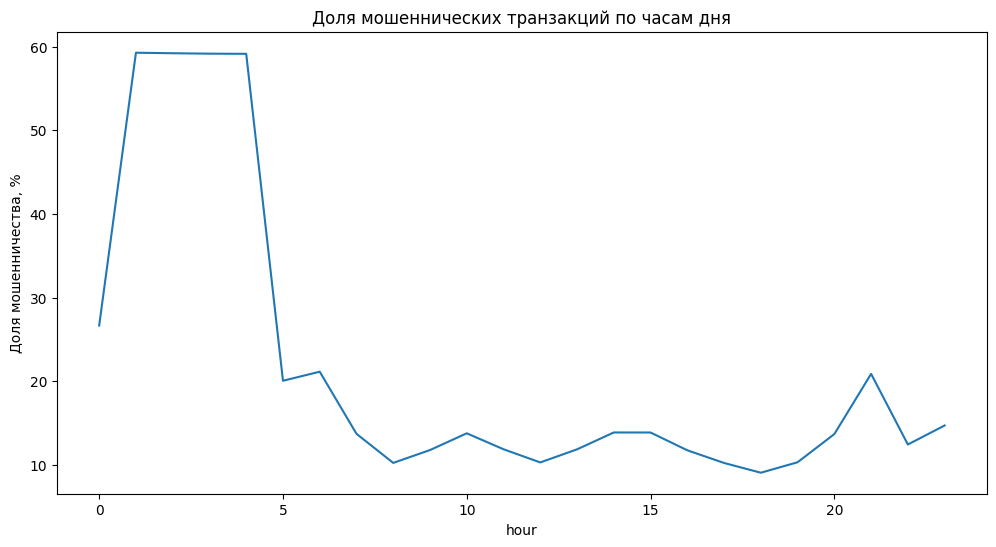

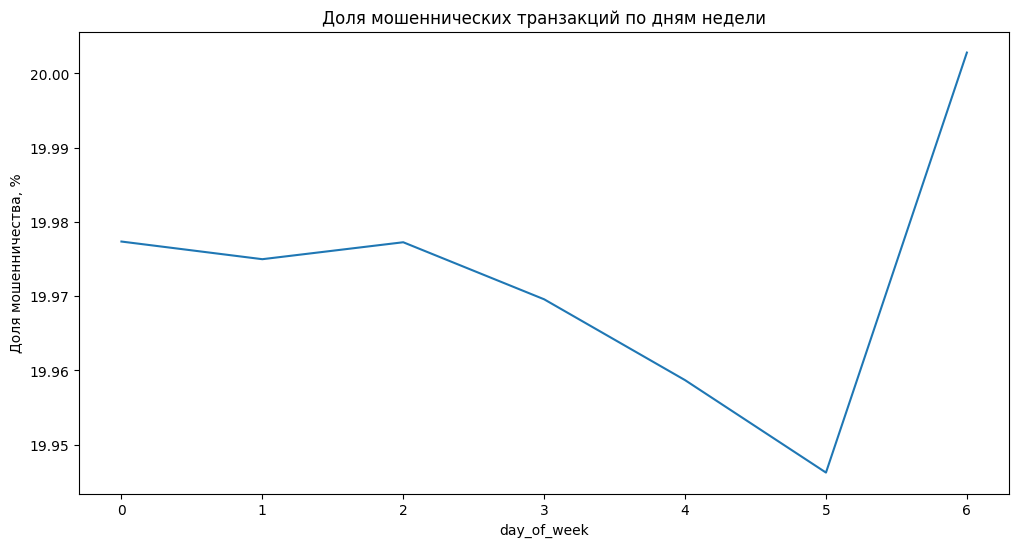

In [ ]:
def analyze_temporal(df):
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_night'] = (df['hour'] < 6) | (df['hour'] > 22)

    hourly_stats = df.groupby('hour')['is_fraud'].agg(['sum', 'count']).reset_index()
    hourly_stats['fraud_rate'] = hourly_stats['sum'] / hourly_stats['count'] * 100
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='hour', y='fraud_rate', data=hourly_stats)
    plt.title('Доля мошеннических транзакций по часам дня')
    plt.ylabel('Доля мошенничества, %')
    plt.show()
    
    week_stats = df.groupby('day_of_week')['is_fraud'].agg(['sum', 'count']).reset_index()
    week_stats['fraud_rate'] = week_stats['sum'] / week_stats['count'] * 100
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='day_of_week', y='fraud_rate', data=week_stats)
    plt.title('Доля мошеннических транзакций по дням недели')
    plt.ylabel('Доля мошенничества, %')
    plt.show()

analyze_temporal(df2)


Больше всего мошеннеческих транзакций совершается ночью и в воскресенье.

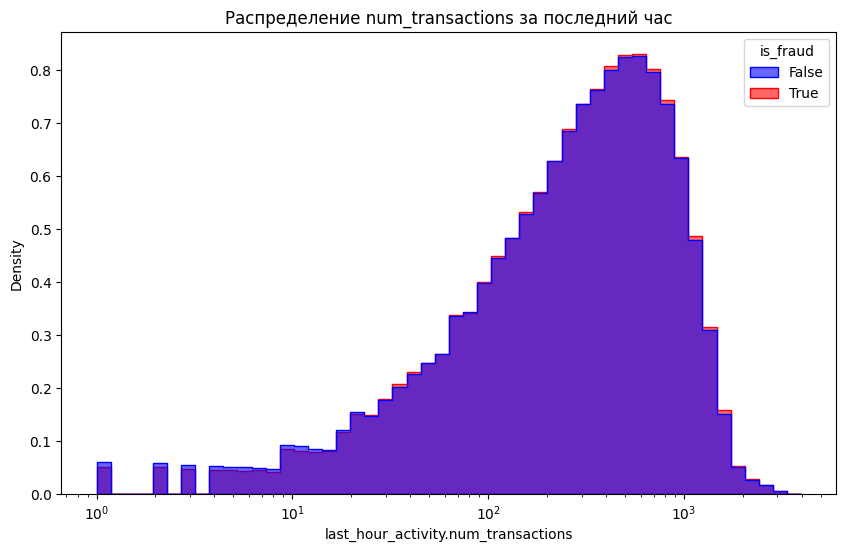

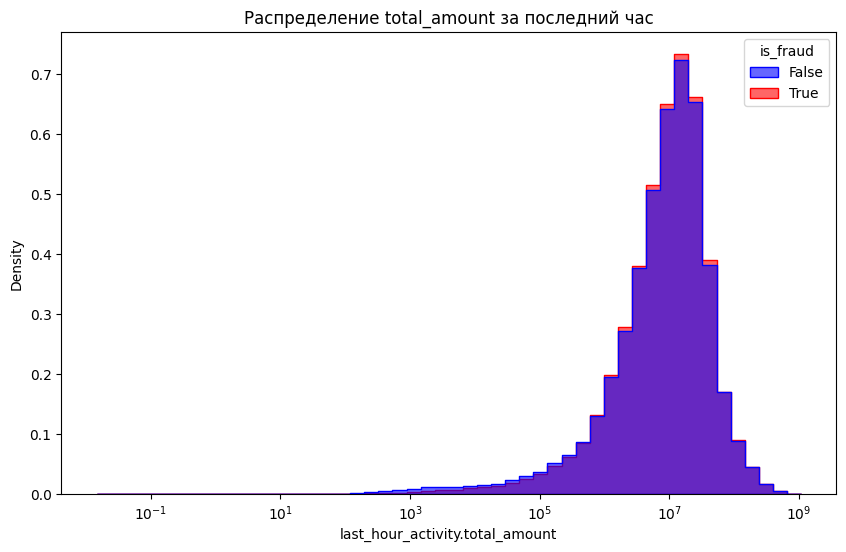

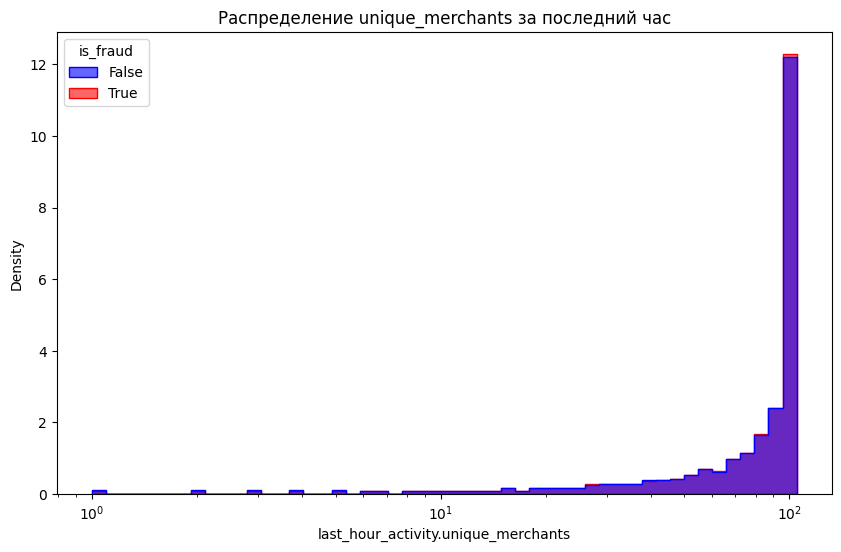

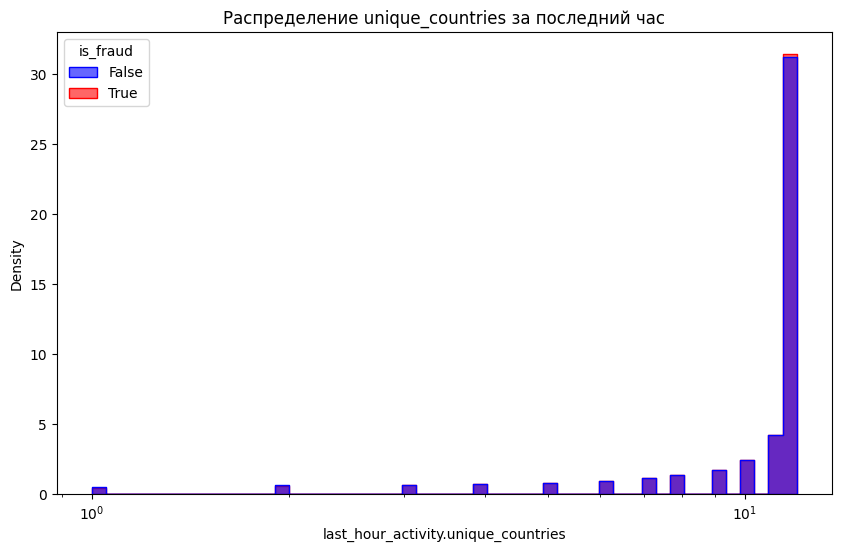

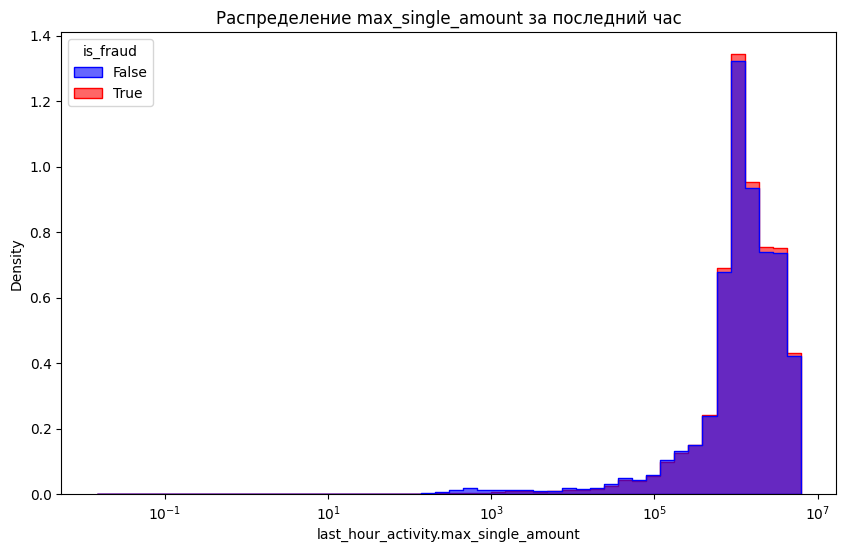

In [15]:
def analyze_last_hour_activity(df):
    metrics = ['num_transactions', 'total_amount', 'unique_merchants', 
               'unique_countries', 'max_single_amount']
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        # sns.boxplot(x='is_fraud', y=f'last_hour_activity.{metric}', data=df)
        sns.histplot(
            data=df,
            x=f'last_hour_activity.{metric}',
            hue='is_fraud',
            bins=50,
            alpha=0.6,
            palette={True: 'red', False: 'blue'},
            element='step',  
            log_scale=True, 
            common_norm=False,
            stat='density'
        )
        plt.title(f'Распределение {metric} за последний час')
        plt.show()

analyze_last_hour_activity(df2)

Распределения признаков из last_hour_activity не отличаются в мошеннеческих и обычных группах.

## Проверка продуктовых гипотез

In [21]:
def test_product_hypotheses(df):
    print("\n=== Проверка продуктовых гипотез ===\n")
    
    large_amount = df['amount_usd'] > df['amount_usd'].quantile(0.95)
    fraud_rate_large = df[large_amount]['is_fraud'].mean()
    fraud_rate_small = df[~large_amount]['is_fraud'].mean()
    print(f"\nГипотеза 1 (большие суммы):")
    print(f"Доля мошенничества для больших сумм: {fraud_rate_large:.2%}")
    print(f"Доля мошенничества для обычных сумм: {fraud_rate_small:.2%}")
    print(f"Отношение: {fraud_rate_large/fraud_rate_small:.1f}x")
    
    outside_country = df['is_outside_home_country'] == True
    fraud_rate_outside = df[outside_country]['is_fraud'].mean()
    fraud_rate_home = df[~outside_country]['is_fraud'].mean()
    print(f"\nГипотеза 2 (транзакции за пределами страны более рискованы):")
    print(f"Доля мошенничества за пределами страны: {fraud_rate_outside:.2%}")
    print(f"Доля мошенничества в домашней стране: {fraud_rate_home:.2%}")
    print(f"Отношение: {fraud_rate_outside/fraud_rate_home:.1f}x")
    
    pos = df['channel'] == 'pos'
    fraud_rate_online = df[pos]['is_fraud'].mean()
    fraud_rate_offline = df[~pos]['is_fraud'].mean()
    print(f"\nГипотеза 3 (pos транзакции более рискованы):")
    print(f"Доля мошенничества в pos: {fraud_rate_online:.2%}")
    print(f"Доля мошенничества не в pos: {fraud_rate_offline:.2%}")
    print(f"Отношение: {fraud_rate_online/fraud_rate_offline:.1f}x")
    
    df['hour'] = df['timestamp'].dt.hour
    night = (df['hour'] < 6) | (df['hour'] > 22)
    fraud_rate_night = df[night]['is_fraud'].mean()
    fraud_rate_day = df[~night]['is_fraud'].mean()
    print(f"\nГипотеза 4 (ночные транзакции более рискованы):")
    print(f"Доля мошенничества ночью: {fraud_rate_night:.2%}")
    print(f"Доля мошенничества днем: {fraud_rate_day:.2%}")
    print(f"Отношение: {fraud_rate_night/fraud_rate_day:.1f}x")

test_product_hypotheses(df2)


=== Проверка продуктовых гипотез ===


Гипотеза 1 (большие суммы):
Доля мошенничества для больших сумм: 62.25%
Доля мошенничества для обычных сумм: 17.75%
Отношение: 3.5x

Гипотеза 2 (транзакции за пределами страны более рискованы):
Доля мошенничества за пределами страны: 56.78%
Доля мошенничества в домашней стране: 2.49%
Отношение: 22.8x

Гипотеза 3 (pos транзакции более рискованы):
Доля мошенничества в pos: 100.00%
Доля мошенничества не в pos: 12.35%
Отношение: 8.1x

Гипотеза 4 (ночные транзакции более рискованы):
Доля мошенничества ночью: 44.62%
Доля мошенничества днем: 12.35%
Отношение: 3.6x


# Выводы

- Мошенники сначала совершают маленькую транзакцию, потом транзакцию на большую сумму. (Может быть паттерн, когда просят заморозить небольшую сумму на карте, для проверки работы).
- Чаще всего мошеннические транзакции происходят за пределами страны пострадавшего.
- POS транзакции наиболее опасны.
- Мошенники чаще действуют ночью.